# Data Science Coca-Cola Aufgabe 


# Problem 

Nachdem wir erfolgreich die Speisekarten von mehr als 120.000 Gastronomien sammeln konnten, ist eine der aktuellen 

Herausforderungen der Aufbau einer Datenpipeline, die die Datensätze bereinigt und über unsere API in die Datenbank 

einspielt. 

Ein besonderes Augenmerk liegt hierbei auf den Preisen der Speisen und Getränke, welche durch die verschiedenen 

Datenquellen in der Regel nicht normalisiert sind. So können die Preise unter Umständen folgenden Formate annehmen: 

- 5,50€
- 5,50 €
- 5.50 €
- 5.50 €
- 5.50,-
- 5.50
- 5,50
- 550


Nicht selten schleichen sich hier auch Fehler bei der Extraktion ein, sodass das Komma oder der Punkt nicht korrekt 

erkannt wird und der Preis statt 5,50€ 550€ beträgt. 

In diesem Ordner findest du eine Sammlung von extrahierten Speisekarten (~1600 Stück). Die Aufgabe besteht nun darin, 

eine Funktion / Methode in Python zu schreiben, welche die Datensätze nimmt, die Preise bereinigt und normalisiert, 

sodass der Preis stets in Cent angeben wird (z.B. 5,50€ = 550). 

Auf Basis dieses bereinigten Datensatzes soll dann die Preisverteilung von Coca Cola visualisiert werden. 

Dies kann als Excel, als matplot Graph oder einem anderen Medium deiner Wahl geschehen. 

Es geht hierbei in erster Linie darum, einen Überblick zu erhalten. 


Sollten Ausreißer in den Werten oder Datensätzen auftreten, sind diese ebenfalls zu bereinigen, zu exkludieren oder 

zumindest zu taggen. Ausreißer könnten bspw. ein Cola Preis von 20cent oder 20€ sein, also Werte, die eindeutig

falsch sind. Außerdem können manche Speisekarten unvollständig oder leer sein. 

<img src="cola3.png">

### Um diese Aufgabe zu erledigen, werde ich die nächsten Schritte unternehmen:

- Ich werde Menüdaten für Speisen, Getränke und Preise aus einer Sammlung von Menüs in einer großen Anzahl von JSON-Dateien lesen. 
- Ich werde die Daten in ein einzelnes DataFrame zur Analyse sammeln und als kombinierte CSV-Datei für einen späteren einfacheren Zugriff speichern. 
- Ich werde die Preise verarbeiten und sie als Cent formatieren.
- Ich werde Coca-Cola Daten vizualizieren

### Zu lösende Probleme: 

1) Nicht alle JSON-Dateien halten sich an das gleiche Schema. Ich habe zwei Methoden implementiert, um die beiden verschiedenen JSON-Schema zu lesen, die im Datensatz gefunden wurden. Alle präsentierten Dateien können gelesen und verarbeitet werden (einige enthalten jedoch keine Daten). Bei der Untersuchung der verschiedenen JSON-Schemata habe ich auch eine Kontrolle implementiert, die eine Liste fehlgeschlagener Dateien zurückgibt, um diese weiter zu untersuchen. Aktuell können alle Dateien erfolgreich verarbeitet werden; sollte jedoch eine Datei nicht gelesen werden können, kann ich sie anhand der Fehlerliste untersuchen. 
2) Der Name Coca Cola erscheint in verschiedenen Formen und Schreibweisen. Ich verwende reguläre Ausdrücke, um so viele Instanzen wie möglich zu erfassen.
3) Unterschiedliche Menüs listen das Getränk in unterschiedlichen Volumengrößen auf.
Ich versuche gängige Größenformate mithilfe regulärer Ausdrücke zu lesen; einige Datensätze müssen jedoch verworfen werden, wenn kein Volumen gelesen werden kann (128 von 2561 oder etwa 5% verworfene Einträge).
4) Derzeit trenne ich nicht zwischen den verschiedenen Geschmacksrichtungen von Coca Cola (Light, Zero usw.), da die Preise normalerweise gleich sind.



## Verarbeitung des Datenordners 

Ich definiere und wende Funktionen an, um mehrere gültige JSON-Menüdateien aus einem Ordner zu lesen, sie in ein Pandas-Datenframe zu transformieren und die Ergebnisse als CSV für später zu speichern.

In [1]:
import pandas as pd
import os
import re
import matplotlib.pyplot as plt

### def process_categories()

In [2]:
""" the function will process a dataframe of the known shape
    categories {
        name, category,
        items[...]
    }
    this is how the majority of the menus are presented
    params:
    df - the dataframe to transform
    file_id - the name of the source file
    returns:
    the processed dataframe
"""
def process_categories(df, file_id):
    df = pd.json_normalize(df["categories"])

    all_items = []
    # iterating categories
    for _, row in df.iterrows():
        cat_name = row["name"]
        cat_desc = row["category"]

        # iterating items within one category
        for i in row["items"]:
            # it will be a dict with name, price, ingredients and description of an item
            # I also add the category info to each item
            # here I also add the file the data came from as "menu_file_id"
            # this also ensures, that entries in the final dataframe remain unique (if the same item is in multiple menus)
            i["category_name"] = cat_name
            i["category_text"] = cat_desc
            i["menu_file_id"] = file_id

            all_items.append(i)
    
    return pd.DataFrame(all_items)

### def process_sections()

In [3]:
""" function will process a dataframe of the shape
    [{model, section_name,
      items[...]
    }]
    params:
    df - the dataframe to process
    file_id - name of the source file
    returns:
    the processed dataframe
"""
def process_sections(df, file_id):
    all_items = []
    for _, row in df.iterrows():
        cat_name = row["model"]
        cat_desc = row["section_name"]

        # iterating over the items in one section
        for i in row["items"]:
            i["category_name"] = cat_name
            i["category_text"] = cat_desc
            i["menu_file_id"] = file_id
            # this JSON schema has preprocessed prices
            # I make the entry conform to our dataframe 
            i["price"] = i["price_raw"]
            i.pop("price_raw", None)

            all_items.append(i)
    
    return pd.DataFrame(all_items)
        


### def read_json_menu()

In [4]:
""" the function will take a filename and return a dataframe from that file
    params:
    filename - the OS filename to read from (should be a json)
    file_is - the source file identifier to write into the df
    returns:
    the contents of the given json menu file as pandas dataframe
    might return None if the given file was not read successfully
"""
def read_json_menu(filename, file_id):

    df = pd.read_json(filename)
    # process files that have recognized shapes
    if "categories" in df.columns:
        return process_categories(df, file_id)
    
    if "section_name" in df.columns:
        return process_sections(df, file_id)
    
    # only happens, if the file was not processed
    return None

### def read_all_json_from_folder()

In [5]:
""" the function will take a folder path, read and process all contained json files
    params:
    folder - the OS path the folder with the json menu files
    returns:
    a tuple containing:
        dataframe with all the information from all files in the given folder
        a list of files that failed to process
        number of files read
        number of files successfully processed
"""         
def read_all_json_from_folder(folder):
    dfs = []
    file_count = 0
    success_count = 0
    fail_list = []
    # iterate through files in the given folder
    for file_id in os.listdir(folder):
        # skip files that aren't json
        if not file_id.endswith(".json"):
            continue

        file_count += 1
        file_path = os.path.join(folder, file_id)
        read_json_menu(file_path, file_id)
        df = read_json_menu(file_path, file_id)
        if df is None:
            fail_list.append(file_id)
        else:
            dfs.append(df)
            success_count += 1

    return pd.concat(dfs, ignore_index=True), fail_list, file_count, success_count

## Lesen und verarbeiten alle JSON-Dateien, die bekannten Schemata entsprechen. 

Ich lese die erkannte Mehrheit der JSON-Dateien und erhalte einen Bericht über Dateien, die nicht gelesen werden konnten, um sie weiter zu untersuchen.


In [6]:
# process json files that adhere to the known schema
folder = "./Datensatz-Probeaufgabe"

full_df, fail_list, file_count, success_count = read_all_json_from_folder(folder)

print(f"Successfully read {success_count} out of {file_count} menus")

Successfully read 1609 out of 1609 menus


In [7]:
# get a list of failed files for further investigation
print("Files that failed to process:")
for e in fail_list:
    print(e)

Files that failed to process:


## Verarbeitung des Dataframes

### def strip_price()

In [8]:
""" function will convert the entry to cents by dropping all characters,
    that are not a digit
    params:
    price - the string representation of a price
    returns:
    the integer price in cents
    None if the price string can not be converted
"""
def strip_price(price_str):
    price = None
    try:
        price = int("".join(filter(str.isdigit, price_str)))
    except ValueError:
        pass

    return price

In [9]:
# create a new column for processed prices. 
# keeping the original price column unchanged, in case it is needed later
full_df.insert(1, "clean_price", full_df["price"].apply(strip_price))

In [10]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67355 entries, 0 to 67354
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           67355 non-null  object 
 1   clean_price    67186 non-null  float64
 2   description    66329 non-null  object 
 3   ingredients    67355 non-null  object 
 4   price          67355 non-null  object 
 5   category_name  67355 non-null  object 
 6   category_text  67351 non-null  object 
 7   menu_file_id   67355 non-null  object 
dtypes: float64(1), object(7)
memory usage: 4.1+ MB


## Schreiben der CSV-Datei für einen einfacheren Zugriff später

In [11]:
# write the data we got as a csv
csv_out = "processed_menus.csv"

print(f"\nWriting successfull data to {csv_out}")    
full_df.to_csv("processed_menus.csv")


Writing successfull data to processed_menus.csv


## Untersuchung der Coca-Cola-Preise

Ich sammle alle Vorkommen von Coca-Cola, die ich mit einem regulären Ausdruck finden kann. Das Getränk wird in verschiedenen Volumengrößen angeboten. Dies wird den Preisvergleich verzerren und erfordert zusätzliche Verarbeitung, um den Preis pro Einheit zu berechnen. Vorläufig werde ich mir nur die Verteilung ansehen und davon ausgehen, dass der Großteil der normalen Verteilung für die gängigste Getränkegröße gilt.


In [12]:
# create a new dataframe filtered for coca-cola
pattern = "Coca[- ]?Cola.*"

cola_df = full_df[full_df["name"].str.contains(pattern, case=False, regex=True)].copy()
cola_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2561 entries, 21 to 67345
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           2561 non-null   object 
 1   clean_price    2561 non-null   float64
 2   description    2561 non-null   object 
 3   ingredients    2561 non-null   object 
 4   price          2561 non-null   object 
 5   category_name  2561 non-null   object 
 6   category_text  2561 non-null   object 
 7   menu_file_id   2561 non-null   object 
dtypes: float64(1), object(7)
memory usage: 180.1+ KB


## Entfernen von Ausreißern basierend auf dem Interquartilsbereich

<img src="cola1.png">

### def trim_iql()

In [13]:
""" function will drop outliers form a given dataframe based on interquantile range
    params:
    df - the input dataframe (will not be changed)
    columnt - numeric column to trim by
    returns:
    a new dataframe cleared of outliers
"""
def trim_iql(df, col):
    q_low = df[col].quantile(0.25)
    q_high = df[col].quantile(0.75)
    iqr = q_high - q_low

    b_low = q_low - 1.5 * iqr
    b_high = q_high + 1.5 * iqr

    return df[(df[col] >= b_low) & (df[col] <= b_high)]

In [14]:
cola_df_iql = trim_iql(cola_df, "clean_price")

## Histogram Plot der Rohpreisverteilung

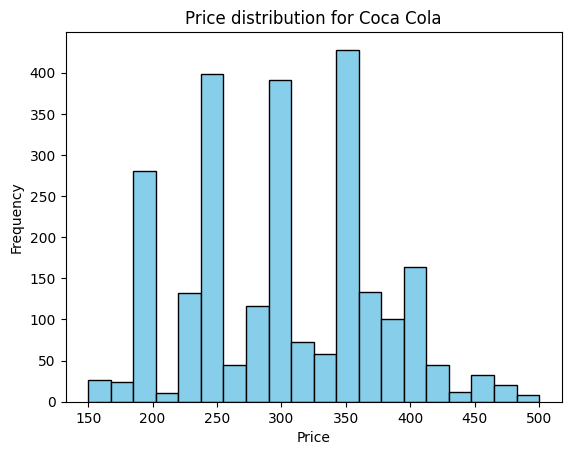

In [15]:
plt.hist(
    cola_df_iql["clean_price"],
    bins=20, color="skyblue", edgecolor="black"
)
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.title("Price distribution for Coca Cola")
plt.grid(False)
plt.show()

Da die Getränke in verschiedenen Größen angeboten werden, kann ich davon ausgehen, dass die Peaks des Histogramms verschiedenen Größen entsprechen. Ich werde versuchen, die Größe aus den Artikelbeschreibungen zu lesen und den Preis pro Liter zu betrachten.

## Versuch, die Getränkegröße zu lesen 

Ich werde versuchen, die Größe des Getränks zu lesen, wenn sie im Namenseintrag enthalten ist. Wenn ein Volumen gefunden werden kann, werde ich es in eine neue Spalte speichern und den Preis pro Liter des Getränks berechnen.

## def read_size()

In [16]:
""" the function will attempt to extract the volume of the drink 
    from the name field of a drink
    params:
    items_text - the menu name of a drink, possibly containing a size
    returns:
    size in liters, if possible
    None otherwise
"""
def read_size(item_text):

    # read volumees given in ml (330ml, 200ml)
    size_pattern_ml = r"(\d+)\s*ml"
    hits = re.findall(size_pattern_ml, item_text)
    if hits:
        return float(hits[0]/1000)

    # read volumes given in l (1.0, ,5, 0.5L etc)
    size_pattern_l = r"(\d*[\.,]?\d+)\s*[lL]"
    hits = re.findall(size_pattern_l, item_text)
    if hits:
        return float(hits[0].replace(",", "."))

    # default if no size was matched. will become Nan in the DF    
    return None

In [17]:
cola_df.insert(2, "drink_size", cola_df["name"].apply(read_size))

In [18]:
cola_df_size = cola_df.dropna(subset="drink_size")
cola_df_size.head()

,name,clean_price,drink_size,description,ingredients,price,category_name,category_text,menu_file_id
64,"Coca-Cola 0,2l (MEHRWEG)",320.0,0.20,,"Coca-Cola steht für einzigartigen Geschmack, E...","3,20 €",Alkoholfreie Getränke,,ChIJwUmsFuQHvUcR93M8kvRhfgY-c448fc7d-a53b-4d67...
126,"Coca-cola 1,0l (mehrweg)",300.0,1.00,,"Coca-cola steht für einzigartigen geschmack, e...","3,00 €",Alkoholfreie Getränke,,ChIJ-8zEUvcHvUcRfHp8W15k4N8-delivery.json
166,"Coca-Cola 0,33l (EINWEG)",220.0,0.33,,"Coca-Cola steht für einzigartigen Geschmack, E...","2,20 €",Alkoholfreie Getränke,,ChIJtSIcZwJxvUcRl7Py2q3e_Sc-delivery.json
195,"Coca Cola 1,0l",350.0,1.00,,"Coca-Cola steht für einzigartigen Geschmack, E...","3,50 €",Alkoholfreie Getränke,,ChIJh48pO8DivEcRl0tJ2pFie6U-delivery.json
196,"Coca Cola light taste 1,0l",350.0,1.00,,Light taste: Leichter als das Original und in ...,"3,50 €",Alkoholfreie Getränke,,ChIJh48pO8DivEcRl0tJ2pFie6U-delivery.json


In [19]:
cola_df_size.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2433 entries, 64 to 67345
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           2433 non-null   object 
 1   clean_price    2433 non-null   float64
 2   drink_size     2433 non-null   float64
 3   description    2433 non-null   object 
 4   ingredients    2433 non-null   object 
 5   price          2433 non-null   object 
 6   category_name  2433 non-null   object 
 7   category_text  2433 non-null   object 
 8   menu_file_id   2433 non-null   object 
dtypes: float64(2), object(7)
memory usage: 190.1+ KB


In [20]:
# drop the NaN entries and the outliers based on IQL (for price per liter, rather than the raw price)
cola_df_size = cola_df.dropna(subset="drink_size")
cola_df_size.insert(3, "price_per_1l", cola_df_size["clean_price"]//cola_df_size["drink_size"])

In [21]:
cola_df_size = trim_iql(cola_df_size, "clean_price")

## Histogram Plot der Preise pro Liter Getränk

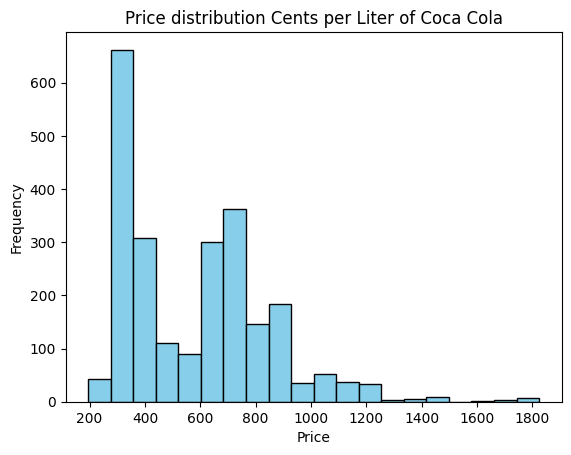

In [22]:
plt.hist(
    cola_df_size["price_per_1l"],
    bins=20, color="skyblue", edgecolor="black"
)
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.title("Price distribution Cents per Liter of Coca Cola")
plt.grid(False)
plt.show()

## Untersuchung der Ausreißer

Bei Preisen von bis zu 18,00 Euro pro Liter vermute ich, dass das IQL-Kriterium für die Ausreißer möglicherweise verschärft werden muss. Ich werfe einen Blick auf einige der Ausreißer, um zu versuchen festzustellen, ob und wie sie Fehler sein könnten. Die Ergebnisse zeigen höhere Preise (pro Liter) für kleinere Getränkeportionen und scheinen konsistent zu sein.

In [23]:
cola_df_outliers = cola_df_size[cola_df_size["price_per_1l"] > 1500]
cola_df_outliers.head()

,name,clean_price,drink_size,price_per_1l,description,ingredients,price,category_name,category_text,menu_file_id
64,"Coca-Cola 0,2l (MEHRWEG)",320.0,0.2,1599.0,,"Coca-Cola steht für einzigartigen Geschmack, E...","3,20 €",Alkoholfreie Getränke,,ChIJwUmsFuQHvUcR93M8kvRhfgY-c448fc7d-a53b-4d67...
3787,"Coca-Cola® Zero 0,2l",350.0,0.2,1749.0,,,"3,50 €",ALKOHOLFREIE GETRÄNKE 🥤,,ChIJyZEfElgJvUcRgBLuk3uE87g-78c18e70-6035-46c0...
6900,"Coca-Cola® 0,2 l",335.0,0.2,1674.0,,,"3,35 €",ALKOHOLFREIE GETRÄNKE 🥤\n,,ChIJWZtKXKUOvUcRYq4pKEbsvHs-delivery.json
6902,"Coca-Cola® Zero 0,2 l",335.0,0.2,1674.0,,,"3,35 €",ALKOHOLFREIE GETRÄNKE 🥤\n,,ChIJWZtKXKUOvUcRYq4pKEbsvHs-delivery.json
10150,"Coca-Cola 0,2l",365.0,0.2,1824.0,,"Coca-Cola steht für einzigartigen Geschmack, E...","3,65 €",Non-Alcoholic Drinks,,ChIJyZEfElgJvUcRgBLuk3uE87g-da266930-3690-43f6...


## Fazit : 

Nachdem mir die Data-Science-Aufgabe übertragen wurde, habe ich mich damit beschäftigt, eine Funktion in Python zu entwickeln, um die Preise zu bereinigen und zu normalisieren. 
Die Preise wurden in verschiedenen Formaten erfasst, wie 5,50€, 5.50 € oder auch fehlerhaft als 550€. Ich habe eine Funktion entwickelt, um die Datensätze zu nehmen und die Preise so zu normalisieren, dass sie immer in Cent angegeben werden (z.B. 5,50€ = 550). 

Anschließend habe ich auf Basis dieses bereinigten Datensatzes die Preisverteilung von Coca Cola visualisiert und Ausreißer identifiziert sowie entsprechend bereinigt oder markiert. Dabei bin ich auf Preise gestoßen, die bis zu 18 Euro pro Liter betrugen und festgestellt, dass das IQL-Kriterium für Ausreißer möglicherweise verschärft werden muss.

Ich konnte außerdem feststellen, dass höhere Preise pro Liter für kleinere Getränkeportionen konsistent sind.
